<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Simpsons Characters recognition using transfer learning - BigTransfer (BiT)

The below codes are adapted from the colab tutorial in https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb

The Simpsons Characters dataset is obtained from https://www.kaggle.com/alexattia/the-simpsons-characters-dataset.
I only used 5 characters from the dataset. 

I use transfer learning in the  baseline model for this experiment. I make use of the BigTransfer model that is already trained on ImageNet and use the convolutional layers as feature extractor and trained a classifier specifically for the Simpsons Characters classification task. The training was done using Nvidia GTX 1660 TI GPU.


In [1]:
#@title Imports
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
simpsons_labels = [
 'bart_simpson',
 'homer_simpson',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson']

In [3]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [4]:
#@title Helper functions for loading image (hidden)

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [5]:
#@title Plotting helper functions (hidden)
#@markdown Credits to Xiaohua Zhai, Lucas Beyer and Alex Kolesnikov from Brain Zurich, Google Research

# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_label=None, tf_simpsons_logits=False):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_label is not None:
    ax1.set_title(simpsons_labels[correct_label])
  classes = []
  scores = []
  logits_max = np.max(logits)
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    score = 1.0/(1.0 + np.exp(-logits[j]))
    if score < MIN_SCORE: break
    if not tf_simpsons_logits:
      # predicting in imagenet label space
      classes.append(imagenet_int_to_str[j])
    else:
      # predicting in tf_flowers label space
      classes.append(simpsons_labels[j])
    scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

In [6]:
data_dir = pathlib.Path("D:\\git\\deeplearning\\simpsons\\simpsons\\big_data")

IMG_HEIGHT = 224
IMG_WIDTH = 224

CLASS_NAMES = simpsons_labels # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.jpg')))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  
  return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img  

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_split = 0.9
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_test = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

In [7]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

In [8]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [9]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 4
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_test(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [10]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [11]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model

#history = model.fit(
#    pipeline_train,
#    batch_size=BATCH_SIZE,
#    steps_per_epoch=STEPS_PER_EPOCH,
#    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
#    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
#)


history = model.fit(
    pipeline_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=30,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/30
10/10 [==============================] - 43s 4s/step - loss: 1.5500 - accuracy: 0.3000 - val_loss: 1.4574 - val_accuracy: 0.2078
Epoch 2/30
10/10 [==============================] - 13s 1s/step - loss: 1.4255 - accuracy: 0.4000 - val_loss: 1.7907 - val_accuracy: 0.3667
Epoch 3/30
10/10 [==============================] - 5s 478ms/step - loss: 1.6838 - accuracy: 0.3250 - val_loss: 1.2215 - val_accuracy: 0.4333
Epoch 4/30
10/10 [==============================] - 5s 492ms/step - loss: 1.2954 - accuracy: 0.4000 - val_loss: 1.0804 - val_accuracy: 0.5863
Epoch 5/30
10/10 [==============================] - 5s 495ms/step - loss: 1.0379 - accuracy: 0.5750 - val_loss: 1.0194 - val_accuracy: 0.6647
Epoch 6/30
10/10 [==============================] - 5s 486ms/step - loss: 0.8946 - accuracy: 0.7250 - val_loss: 1.0527 - val_accuracy: 0.5980
Epoch 7/30
10/10 [==============================] - 5s 489ms/step - loss: 0.9228 - accuracy: 0.6750 - val_loss: 0.9599 - val_accuracy: 0.6902
Epoch 8/30

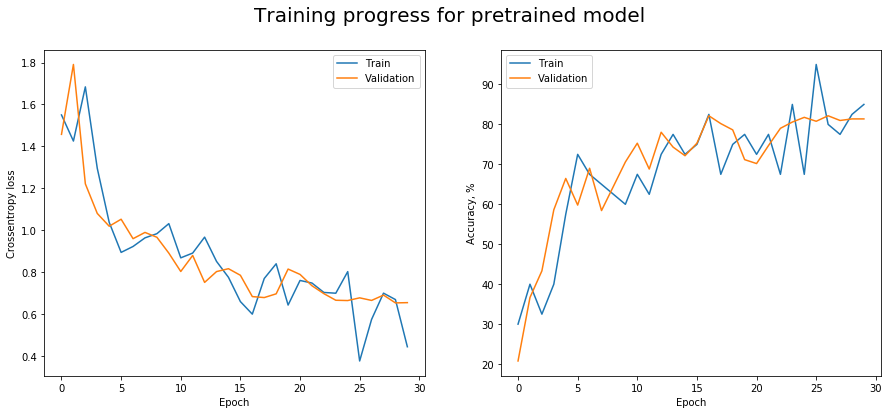

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.suptitle("Training progress for pretrained model", fontsize=20)

plt.subplot(121)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.ylabel("Crossentropy loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(np.array(history.history["accuracy"]) * 100, label="Train")
plt.plot(np.array(history.history["val_accuracy"]) * 100, label="Validation")
plt.legend()
plt.ylabel("Accuracy, %")
plt.xlabel("Epoch");

We see that our model attains around 80% training and validation accuracy.

In [13]:
# Save fine-tuned model as SavedModel
export_module_dir = 'D:\\git\\deeplearning\\simpsons\\simpsons\\models'
tf.saved_model.save(model, export_module_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: D:\git\deeplearning\simpsons\simpsons\models\assets


INFO:tensorflow:Assets written to: D:\git\deeplearning\simpsons\simpsons\models\assets


In [14]:
# Load saved model
saved_module = hub.KerasLayer(export_module_dir, trainable=True)

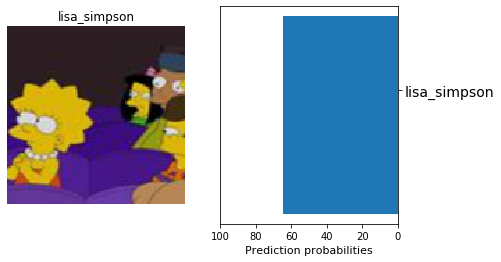

In [18]:
# Visualise predictions from new model
for features in ds_test.take(1):
  image = features['image']
  image = preprocess_image(image)
  image = tf.image.resize(image, [CROP_TO, CROP_TO])

  # Run model on image
  logits = saved_module(image)
  #logits = model(image)
  
  # Show image and predictions
  show_preds(logits, image[0], correct_label=features['label'].numpy(), tf_simpsons_logits=True)